In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications import VGG16  # Replace with desired pre-trained model
import cv2  # Assuming OpenCV is installed for image loading


In [2]:
# Define paths to your train, validation, and test directories
train_path = "assets/dataset/glaucoma/train"
validation_path = "assets/dataset/glaucoma/val"
test_path = "assets/dataset/glaucoma/test"

def load_images(path, target_size=(224, 224)):
    images = []
    labels = []
    class_folders = os.listdir(path)  # Get class folders (0, 1)

    for class_folder in class_folders:
        class_path = os.path.join(path, class_folder)
        for filename in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, filename))
            img = cv2.resize(img, target_size)
            images.append(img)
            # Assuming class label is the folder name (0 or 1)
            label = int(class_folder)
            labels.append(label)

    return np.array(images), np.array(labels)

In [3]:
# Load train, validation, and test data
train_images, train_labels = load_images(train_path)
validation_images, validation_labels = load_images(validation_path)
test_images, test_labels = load_images(test_path)

# Preprocess images (normalize, etc.)
train_images = train_images.astype("float32") / 255.0
validation_images = validation_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

In [4]:
# Feature extraction using pre-trained model
# Load the pre-trained model without the final classification layer (bottleneck features)
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained model weights (optional)
for layer in model.layers:
    layer.trainable = False

# Extract features from train, validation, and test images
train_features = model.predict(train_images)
validation_features = model.predict(validation_images)
test_features = model.predict(test_images)

# Reshape features (if necessary)
train_features = train_features.reshape(train_features.shape[0], -1)
validation_features = validation_features.reshape(validation_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

90/90 [==============================] - 4s 49ms/step


In [5]:
# Train SVM classifier
svm_clf = SVC(kernel="linear")  # Adjust kernel parameter as needed
svm_clf.fit(train_features, train_labels)

SVC(kernel='linear')

In [6]:
# Evaluate on validation set
svm_predictions = svm_clf.predict(validation_features)
svm_predictions

array([0, 0, 0, ..., 1, 1, 1])

In [7]:
svm_accuracy = accuracy_score(validation_labels, svm_predictions)
svm_accuracy

0.9970419349225683

In [8]:
svm_report = classification_report(validation_labels, svm_predictions)
svm_report

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      3539\n           1       1.00      1.00      1.00      2208\n\n    accuracy                           1.00      5747\n   macro avg       1.00      1.00      1.00      5747\nweighted avg       1.00      1.00      1.00      5747\n'

In [9]:
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:\n", svm_report)

SVM Accuracy: 0.9970419349225683
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3539
           1       1.00      1.00      1.00      2208

    accuracy                           1.00      5747
   macro avg       1.00      1.00      1.00      5747
weighted avg       1.00      1.00      1.00      5747


In [10]:
# Test on unseen data
test_predictions_svm = svm_clf.predict(test_features)
test_predictions_svm

array([0, 0, 0, ..., 1, 1, 1])

In [11]:
test_accuracy_svm = accuracy_score(test_labels, test_predictions_svm)
test_accuracy_svm

0.9982602644398052

In [12]:
test_report_svm = classification_report(test_labels, test_predictions_svm)
test_report_svm

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      1754\n           1       1.00      1.00      1.00      1120\n\n    accuracy                           1.00      2874\n   macro avg       1.00      1.00      1.00      2874\nweighted avg       1.00      1.00      1.00      2874\n'

In [15]:
print("SVM Accuracy:", test_accuracy_svm)
print("SVM Classification Report:\n", test_report_svm)

SVM Accuracy: 0.9982602644398052
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1754
           1       1.00      1.00      1.00      1120

    accuracy                           1.00      2874
   macro avg       1.00      1.00      1.00      2874
weighted avg       1.00      1.00      1.00      2874


In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_predictions_svm)
cm

array([[1754,    0],
       [   5, 1115]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

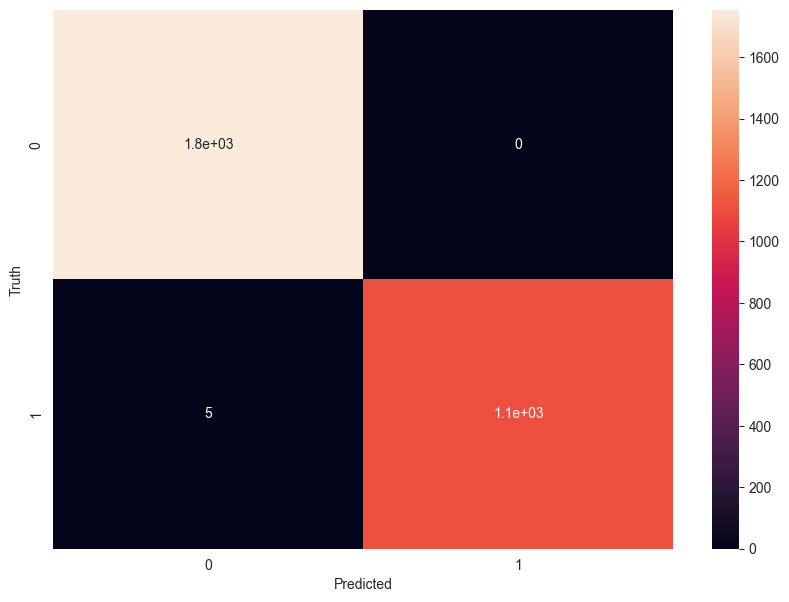

In [14]:
from matplotlib import pyplot as plt
import seaborn as sn

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')